In [8]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.optim as optim
import torch.nn.init as init
from collections import Counter
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import pickle

In [9]:
dist = np.load('./distribution.npy')

In [10]:
def sample2d(dist, n):
    dist_flat = dist.reshape([-1])
    x1_max, x2_max = dist.shape
    raw_samples = np.random.choice(np.arange(0, x1_max * x2_max), size=[n], p=dist_flat)
    samples = [[s // x2_max, s % x2_max] for s in raw_samples]
    return np.array(samples)

samples = sample2d(dist, 100000)
X_train = torch.Tensor(samples[:60000 ]).int().cuda()
X_val = torch.Tensor(samples[60000:80000]).int().cuda()
X_test = torch.Tensor(samples[80000:]).int().cuda()

<IPython.core.display.Javascript object>


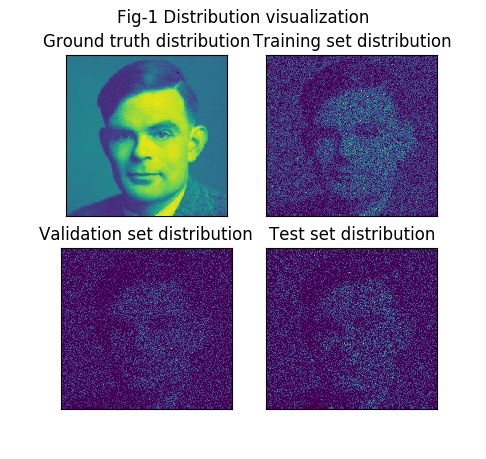

Text(0.5, 0.98, 'Fig-1 Distribution visualization')

In [11]:
# plot the sampled distribution of the three sets
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(dist)
axes[0, 0].set_title("Ground truth distribution")
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

X_train_np = X_train.data.cpu().numpy()
axes[0, 1].hist2d(X_train_np[:, 1], X_train_np[:, 0], bins=[200, 200])
axes[0, 1].invert_yaxis()
axes[0, 1].set_title("Training set distribution")
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

X_val_np = X_val.data.cpu().numpy()
axes[1, 0].hist2d(X_val_np[:, 1], X_val_np[:, 0], bins=[200, 200])
axes[1, 0].invert_yaxis()
axes[1, 0].set_title("Validation set distribution")
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

X_test_np = X_test.data.cpu().numpy()
axes[1, 1].hist2d(X_test_np[:, 1], X_test_np[:, 0], bins=[200, 200])
axes[1, 1].invert_yaxis()
axes[1, 1].set_title("Test set distribution")
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

fig.suptitle("Fig-1 Distribution visualization")

In [12]:
class MyModel(nn.Module):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.theta = nn.Parameter(torch.zeros([200]).float())
        self.layer1 = nn.Sequential(nn.Linear(200, 200),
#                                     nn.Dropout(0.3),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(200, 200),
                                    nn.Softmax(dim=1))
        
    def forward(self, X):
        prob1 = torch.softmax(self.theta, dim=0)[X.long()[:, 0:1]]
        x1_onehot = torch.zeros(X.shape[0], 200).cuda().scatter_(1, X[:, 0:1].long(), 1)
        out1 = self.layer1(x1_onehot)
        out2 = self.layer2(out1)
        prob2 = torch.gather(out2, 1, X[:, 1:].long())
        joint_prob = prob1 * prob2
        return joint_prob, prob1, prob2
    
    def get_distribution(self):
        prob1 = torch.softmax(self.theta, dim=0)
        x1_onehot = torch.eye(200).cuda()
        prob2 = self.layer2(self.layer1(x1_onehot))
        return (prob2 * prob1).detach().cpu().data.numpy()
    

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        init.zeros_(m.bias.data)
    return
    
def get_NLL(prob):
    return -torch.mean(torch.log2(prob))

def save_checkpoint(state, save_dir, ckpt_name='best.pth.tar'):
    file_path = os.path.join(save_dir, ckpt_name)
    if not os.path.exists(save_dir):
        print("Save directory dosen't exist! Makind directory {}".format(save_dir))
        os.mkdir(save_dir)
    
    torch.save(state, file_path)
    
def load_checkpoint(checkpoint, model):
    if not os.path.exists(checkpoint):
        raise Exception("File {} dosen't exists!".foramt(checkpoint))
    checkpoint = torch.load(checkpoint)
    saved_dict = checkpoint['state_dict']
    new_dict = model.state_dict()
    new_dict.update(saved_dict)
    model.load_state_dict(new_dict)

In [13]:
model = MyModel().cuda()
model.apply(initialize_weights)

MyModel(
  (layer1): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): Softmax()
  )
)

In [14]:
lr = 1e-3
best_nll = np.inf
save_dir = './checkpoints/MLP'
train_log = []
val_log = []

n_epochs = 500
batch_size = 5000
n_iter_per_epoch = X_train.shape[0] // batch_size

optimizer = optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):
    idx = torch.randperm(X_train.shape[0])
    for j in range(n_iter_per_epoch):
        model.train()
        X = X_train[idx[j * batch_size: (j + 1) * batch_size]]
        p, _, _ = model(X)
        loss = -torch.mean(torch.log(p))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        p_train, _, _ = model(X)
        nll_train = get_NLL(p_train) / 2.0 
        train_log.append(nll_train.detach().item())

        p_val, _, _ = model(X_val)
        nll_val = get_NLL(p_val) / 2.0
        val_log.append(nll_val.detach().item())
        print("Epoch-{:d}/{:d} Iter-{:d}/{:d} loss: {:.4f}, train_bits: {:.3f}, val_bits: {:.3f}".format(i + 1, n_epochs, j + 1, n_iter_per_epoch, loss, nll_train, nll_val))

        if nll_val < best_nll:
            best_nll = nll_val
            save_checkpoint({'epoch': i,
                             'state_dict': model.state_dict()}, save_dir)

save_checkpoint({'epoch': i, 'state_dict': model.state_dict()}, save_dir, ckpt_name='last.pth.tar')

Epoch-1/500 Iter-1/12 loss: 10.5970, train_bits: 7.642, val_bits: 7.643
Epoch-1/500 Iter-2/12 loss: 10.5963, train_bits: 7.642, val_bits: 7.643
Epoch-1/500 Iter-3/12 loss: 10.5959, train_bits: 7.642, val_bits: 7.642
Epoch-1/500 Iter-4/12 loss: 10.5954, train_bits: 7.642, val_bits: 7.642
Epoch-1/500 Iter-5/12 loss: 10.5943, train_bits: 7.641, val_bits: 7.641
Epoch-1/500 Iter-6/12 loss: 10.5931, train_bits: 7.640, val_bits: 7.641
Epoch-1/500 Iter-7/12 loss: 10.5927, train_bits: 7.640, val_bits: 7.640
Epoch-1/500 Iter-8/12 loss: 10.5916, train_bits: 7.639, val_bits: 7.640
Epoch-1/500 Iter-9/12 loss: 10.5911, train_bits: 7.639, val_bits: 7.639
Epoch-1/500 Iter-10/12 loss: 10.5904, train_bits: 7.639, val_bits: 7.639
Epoch-1/500 Iter-11/12 loss: 10.5894, train_bits: 7.638, val_bits: 7.638
Epoch-1/500 Iter-12/12 loss: 10.5894, train_bits: 7.638, val_bits: 7.638
Epoch-2/500 Iter-1/12 loss: 10.5868, train_bits: 7.636, val_bits: 7.637
Epoch-2/500 Iter-2/12 loss: 10.5856, train_bits: 7.635, val_b

Epoch-10/500 Iter-10/12 loss: 10.5340, train_bits: 7.598, val_bits: 7.615
Epoch-10/500 Iter-11/12 loss: 10.5228, train_bits: 7.590, val_bits: 7.615
Epoch-10/500 Iter-12/12 loss: 10.5330, train_bits: 7.597, val_bits: 7.615
Epoch-11/500 Iter-1/12 loss: 10.5213, train_bits: 7.589, val_bits: 7.615
Epoch-11/500 Iter-2/12 loss: 10.5219, train_bits: 7.589, val_bits: 7.614
Epoch-11/500 Iter-3/12 loss: 10.5224, train_bits: 7.590, val_bits: 7.614
Epoch-11/500 Iter-4/12 loss: 10.5302, train_bits: 7.595, val_bits: 7.614
Epoch-11/500 Iter-5/12 loss: 10.5219, train_bits: 7.589, val_bits: 7.614
Epoch-11/500 Iter-6/12 loss: 10.5231, train_bits: 7.590, val_bits: 7.614
Epoch-11/500 Iter-7/12 loss: 10.5289, train_bits: 7.594, val_bits: 7.614
Epoch-11/500 Iter-8/12 loss: 10.5208, train_bits: 7.589, val_bits: 7.614
Epoch-11/500 Iter-9/12 loss: 10.5237, train_bits: 7.591, val_bits: 7.614
Epoch-11/500 Iter-10/12 loss: 10.5229, train_bits: 7.590, val_bits: 7.614
Epoch-11/500 Iter-11/12 loss: 10.5241, train_bi

Epoch-21/500 Iter-7/12 loss: 10.4453, train_bits: 7.534, val_bits: 7.613
Epoch-21/500 Iter-8/12 loss: 10.4506, train_bits: 7.538, val_bits: 7.613
Epoch-21/500 Iter-9/12 loss: 10.4542, train_bits: 7.540, val_bits: 7.613
Epoch-21/500 Iter-10/12 loss: 10.4472, train_bits: 7.535, val_bits: 7.613
Epoch-21/500 Iter-11/12 loss: 10.4593, train_bits: 7.544, val_bits: 7.613
Epoch-21/500 Iter-12/12 loss: 10.4415, train_bits: 7.531, val_bits: 7.613
Epoch-22/500 Iter-1/12 loss: 10.4448, train_bits: 7.533, val_bits: 7.613
Epoch-22/500 Iter-2/12 loss: 10.4493, train_bits: 7.536, val_bits: 7.613
Epoch-22/500 Iter-3/12 loss: 10.4483, train_bits: 7.536, val_bits: 7.614
Epoch-22/500 Iter-4/12 loss: 10.4416, train_bits: 7.531, val_bits: 7.614
Epoch-22/500 Iter-5/12 loss: 10.4505, train_bits: 7.537, val_bits: 7.614
Epoch-22/500 Iter-6/12 loss: 10.4381, train_bits: 7.528, val_bits: 7.614
Epoch-22/500 Iter-7/12 loss: 10.4421, train_bits: 7.531, val_bits: 7.614
Epoch-22/500 Iter-8/12 loss: 10.4484, train_bits

Epoch-31/500 Iter-2/12 loss: 10.3807, train_bits: 7.487, val_bits: 7.633
Epoch-31/500 Iter-3/12 loss: 10.3703, train_bits: 7.479, val_bits: 7.633
Epoch-31/500 Iter-4/12 loss: 10.3776, train_bits: 7.485, val_bits: 7.633
Epoch-31/500 Iter-5/12 loss: 10.3835, train_bits: 7.489, val_bits: 7.633
Epoch-31/500 Iter-6/12 loss: 10.3860, train_bits: 7.491, val_bits: 7.634
Epoch-31/500 Iter-7/12 loss: 10.3771, train_bits: 7.484, val_bits: 7.634
Epoch-31/500 Iter-8/12 loss: 10.3851, train_bits: 7.490, val_bits: 7.634
Epoch-31/500 Iter-9/12 loss: 10.3740, train_bits: 7.482, val_bits: 7.635
Epoch-31/500 Iter-10/12 loss: 10.3879, train_bits: 7.492, val_bits: 7.635
Epoch-31/500 Iter-11/12 loss: 10.3751, train_bits: 7.483, val_bits: 7.635
Epoch-31/500 Iter-12/12 loss: 10.3813, train_bits: 7.487, val_bits: 7.635
Epoch-32/500 Iter-1/12 loss: 10.3701, train_bits: 7.479, val_bits: 7.635
Epoch-32/500 Iter-2/12 loss: 10.3742, train_bits: 7.482, val_bits: 7.636
Epoch-32/500 Iter-3/12 loss: 10.3764, train_bits

Epoch-41/500 Iter-7/12 loss: 10.3214, train_bits: 7.444, val_bits: 7.665
Epoch-41/500 Iter-8/12 loss: 10.3336, train_bits: 7.453, val_bits: 7.665
Epoch-41/500 Iter-9/12 loss: 10.3410, train_bits: 7.458, val_bits: 7.665
Epoch-41/500 Iter-10/12 loss: 10.3332, train_bits: 7.453, val_bits: 7.666
Epoch-41/500 Iter-11/12 loss: 10.3304, train_bits: 7.450, val_bits: 7.666
Epoch-41/500 Iter-12/12 loss: 10.3350, train_bits: 7.454, val_bits: 7.666
Epoch-42/500 Iter-1/12 loss: 10.3197, train_bits: 7.442, val_bits: 7.666
Epoch-42/500 Iter-2/12 loss: 10.3268, train_bits: 7.448, val_bits: 7.666
Epoch-42/500 Iter-3/12 loss: 10.3201, train_bits: 7.443, val_bits: 7.667
Epoch-42/500 Iter-4/12 loss: 10.3263, train_bits: 7.447, val_bits: 7.667
Epoch-42/500 Iter-5/12 loss: 10.3266, train_bits: 7.448, val_bits: 7.667
Epoch-42/500 Iter-6/12 loss: 10.3189, train_bits: 7.442, val_bits: 7.668
Epoch-42/500 Iter-7/12 loss: 10.3352, train_bits: 7.454, val_bits: 7.668
Epoch-42/500 Iter-8/12 loss: 10.3383, train_bits

Epoch-51/500 Iter-9/12 loss: 10.3100, train_bits: 7.436, val_bits: 7.692
Epoch-51/500 Iter-10/12 loss: 10.3021, train_bits: 7.430, val_bits: 7.692
Epoch-51/500 Iter-11/12 loss: 10.3146, train_bits: 7.439, val_bits: 7.692
Epoch-51/500 Iter-12/12 loss: 10.3007, train_bits: 7.429, val_bits: 7.692
Epoch-52/500 Iter-1/12 loss: 10.2880, train_bits: 7.419, val_bits: 7.692
Epoch-52/500 Iter-2/12 loss: 10.2917, train_bits: 7.422, val_bits: 7.693
Epoch-52/500 Iter-3/12 loss: 10.2871, train_bits: 7.419, val_bits: 7.693
Epoch-52/500 Iter-4/12 loss: 10.3002, train_bits: 7.429, val_bits: 7.693
Epoch-52/500 Iter-5/12 loss: 10.2977, train_bits: 7.427, val_bits: 7.693
Epoch-52/500 Iter-6/12 loss: 10.3052, train_bits: 7.433, val_bits: 7.693
Epoch-52/500 Iter-7/12 loss: 10.3052, train_bits: 7.433, val_bits: 7.694
Epoch-52/500 Iter-8/12 loss: 10.3120, train_bits: 7.437, val_bits: 7.694
Epoch-52/500 Iter-9/12 loss: 10.2977, train_bits: 7.427, val_bits: 7.694
Epoch-52/500 Iter-10/12 loss: 10.2898, train_bit

Epoch-61/500 Iter-6/12 loss: 10.2807, train_bits: 7.415, val_bits: 7.713
Epoch-61/500 Iter-7/12 loss: 10.2821, train_bits: 7.416, val_bits: 7.713
Epoch-61/500 Iter-8/12 loss: 10.2856, train_bits: 7.418, val_bits: 7.713
Epoch-61/500 Iter-9/12 loss: 10.2831, train_bits: 7.417, val_bits: 7.713
Epoch-61/500 Iter-10/12 loss: 10.2802, train_bits: 7.414, val_bits: 7.713
Epoch-61/500 Iter-11/12 loss: 10.2828, train_bits: 7.416, val_bits: 7.713
Epoch-61/500 Iter-12/12 loss: 10.2882, train_bits: 7.420, val_bits: 7.713
Epoch-62/500 Iter-1/12 loss: 10.2739, train_bits: 7.409, val_bits: 7.714
Epoch-62/500 Iter-2/12 loss: 10.2894, train_bits: 7.421, val_bits: 7.714
Epoch-62/500 Iter-3/12 loss: 10.2673, train_bits: 7.405, val_bits: 7.714
Epoch-62/500 Iter-4/12 loss: 10.2640, train_bits: 7.402, val_bits: 7.714
Epoch-62/500 Iter-5/12 loss: 10.2743, train_bits: 7.410, val_bits: 7.714
Epoch-62/500 Iter-6/12 loss: 10.2810, train_bits: 7.415, val_bits: 7.715
Epoch-62/500 Iter-7/12 loss: 10.2867, train_bits

Epoch-71/500 Iter-8/12 loss: 10.2590, train_bits: 7.399, val_bits: 7.731
Epoch-71/500 Iter-9/12 loss: 10.2721, train_bits: 7.409, val_bits: 7.731
Epoch-71/500 Iter-10/12 loss: 10.2672, train_bits: 7.405, val_bits: 7.731
Epoch-71/500 Iter-11/12 loss: 10.2721, train_bits: 7.409, val_bits: 7.731
Epoch-71/500 Iter-12/12 loss: 10.2587, train_bits: 7.399, val_bits: 7.731
Epoch-72/500 Iter-1/12 loss: 10.2508, train_bits: 7.393, val_bits: 7.731
Epoch-72/500 Iter-2/12 loss: 10.2518, train_bits: 7.393, val_bits: 7.731
Epoch-72/500 Iter-3/12 loss: 10.2624, train_bits: 7.401, val_bits: 7.731
Epoch-72/500 Iter-4/12 loss: 10.2646, train_bits: 7.403, val_bits: 7.731
Epoch-72/500 Iter-5/12 loss: 10.2576, train_bits: 7.398, val_bits: 7.731
Epoch-72/500 Iter-6/12 loss: 10.2632, train_bits: 7.402, val_bits: 7.732
Epoch-72/500 Iter-7/12 loss: 10.2674, train_bits: 7.405, val_bits: 7.732
Epoch-72/500 Iter-8/12 loss: 10.2676, train_bits: 7.405, val_bits: 7.732
Epoch-72/500 Iter-9/12 loss: 10.2682, train_bits

Epoch-81/500 Iter-5/12 loss: 10.2616, train_bits: 7.401, val_bits: 7.745
Epoch-81/500 Iter-6/12 loss: 10.2567, train_bits: 7.397, val_bits: 7.745
Epoch-81/500 Iter-7/12 loss: 10.2523, train_bits: 7.394, val_bits: 7.745
Epoch-81/500 Iter-8/12 loss: 10.2529, train_bits: 7.395, val_bits: 7.745
Epoch-81/500 Iter-9/12 loss: 10.2460, train_bits: 7.390, val_bits: 7.745
Epoch-81/500 Iter-10/12 loss: 10.2707, train_bits: 7.407, val_bits: 7.745
Epoch-81/500 Iter-11/12 loss: 10.2525, train_bits: 7.395, val_bits: 7.745
Epoch-81/500 Iter-12/12 loss: 10.2678, train_bits: 7.406, val_bits: 7.745
Epoch-82/500 Iter-1/12 loss: 10.2585, train_bits: 7.398, val_bits: 7.745
Epoch-82/500 Iter-2/12 loss: 10.2385, train_bits: 7.384, val_bits: 7.745
Epoch-82/500 Iter-3/12 loss: 10.2403, train_bits: 7.385, val_bits: 7.745
Epoch-82/500 Iter-4/12 loss: 10.2636, train_bits: 7.402, val_bits: 7.746
Epoch-82/500 Iter-5/12 loss: 10.2440, train_bits: 7.388, val_bits: 7.746
Epoch-82/500 Iter-6/12 loss: 10.2476, train_bits

Epoch-92/500 Iter-1/12 loss: 10.2462, train_bits: 7.389, val_bits: 7.758
Epoch-92/500 Iter-2/12 loss: 10.2376, train_bits: 7.383, val_bits: 7.758
Epoch-92/500 Iter-3/12 loss: 10.2393, train_bits: 7.384, val_bits: 7.758
Epoch-92/500 Iter-4/12 loss: 10.2577, train_bits: 7.398, val_bits: 7.759
Epoch-92/500 Iter-5/12 loss: 10.2454, train_bits: 7.389, val_bits: 7.759
Epoch-92/500 Iter-6/12 loss: 10.2336, train_bits: 7.381, val_bits: 7.759
Epoch-92/500 Iter-7/12 loss: 10.2339, train_bits: 7.381, val_bits: 7.759
Epoch-92/500 Iter-8/12 loss: 10.2525, train_bits: 7.395, val_bits: 7.760
Epoch-92/500 Iter-9/12 loss: 10.2556, train_bits: 7.397, val_bits: 7.760
Epoch-92/500 Iter-10/12 loss: 10.2705, train_bits: 7.407, val_bits: 7.760
Epoch-92/500 Iter-11/12 loss: 10.2325, train_bits: 7.380, val_bits: 7.760
Epoch-92/500 Iter-12/12 loss: 10.2287, train_bits: 7.377, val_bits: 7.759
Epoch-93/500 Iter-1/12 loss: 10.2346, train_bits: 7.381, val_bits: 7.759
Epoch-93/500 Iter-2/12 loss: 10.2470, train_bits

Epoch-102/500 Iter-5/12 loss: 10.2337, train_bits: 7.381, val_bits: 7.770
Epoch-102/500 Iter-6/12 loss: 10.2215, train_bits: 7.372, val_bits: 7.771
Epoch-102/500 Iter-7/12 loss: 10.2251, train_bits: 7.375, val_bits: 7.771
Epoch-102/500 Iter-8/12 loss: 10.2324, train_bits: 7.380, val_bits: 7.771
Epoch-102/500 Iter-9/12 loss: 10.2556, train_bits: 7.397, val_bits: 7.771
Epoch-102/500 Iter-10/12 loss: 10.2408, train_bits: 7.386, val_bits: 7.771
Epoch-102/500 Iter-11/12 loss: 10.2446, train_bits: 7.389, val_bits: 7.771
Epoch-102/500 Iter-12/12 loss: 10.2386, train_bits: 7.384, val_bits: 7.771
Epoch-103/500 Iter-1/12 loss: 10.2390, train_bits: 7.384, val_bits: 7.770
Epoch-103/500 Iter-2/12 loss: 10.2437, train_bits: 7.388, val_bits: 7.771
Epoch-103/500 Iter-3/12 loss: 10.2198, train_bits: 7.371, val_bits: 7.771
Epoch-103/500 Iter-4/12 loss: 10.2299, train_bits: 7.378, val_bits: 7.771
Epoch-103/500 Iter-5/12 loss: 10.2227, train_bits: 7.373, val_bits: 7.771
Epoch-103/500 Iter-6/12 loss: 10.22

Epoch-112/500 Iter-9/12 loss: 10.2286, train_bits: 7.377, val_bits: 7.782
Epoch-112/500 Iter-10/12 loss: 10.2486, train_bits: 7.391, val_bits: 7.782
Epoch-112/500 Iter-11/12 loss: 10.2354, train_bits: 7.382, val_bits: 7.781
Epoch-112/500 Iter-12/12 loss: 10.2397, train_bits: 7.385, val_bits: 7.781
Epoch-113/500 Iter-1/12 loss: 10.2345, train_bits: 7.381, val_bits: 7.781
Epoch-113/500 Iter-2/12 loss: 10.2075, train_bits: 7.362, val_bits: 7.781
Epoch-113/500 Iter-3/12 loss: 10.2281, train_bits: 7.376, val_bits: 7.781
Epoch-113/500 Iter-4/12 loss: 10.2326, train_bits: 7.380, val_bits: 7.781
Epoch-113/500 Iter-5/12 loss: 10.2284, train_bits: 7.377, val_bits: 7.782
Epoch-113/500 Iter-6/12 loss: 10.2326, train_bits: 7.380, val_bits: 7.782
Epoch-113/500 Iter-7/12 loss: 10.2349, train_bits: 7.382, val_bits: 7.782
Epoch-113/500 Iter-8/12 loss: 10.2235, train_bits: 7.374, val_bits: 7.782
Epoch-113/500 Iter-9/12 loss: 10.2409, train_bits: 7.386, val_bits: 7.782
Epoch-113/500 Iter-10/12 loss: 10.2

Epoch-122/500 Iter-6/12 loss: 10.2194, train_bits: 7.371, val_bits: 7.791
Epoch-122/500 Iter-7/12 loss: 10.2327, train_bits: 7.380, val_bits: 7.791
Epoch-122/500 Iter-8/12 loss: 10.2202, train_bits: 7.371, val_bits: 7.791
Epoch-122/500 Iter-9/12 loss: 10.2167, train_bits: 7.369, val_bits: 7.791
Epoch-122/500 Iter-10/12 loss: 10.2316, train_bits: 7.379, val_bits: 7.791
Epoch-122/500 Iter-11/12 loss: 10.2129, train_bits: 7.366, val_bits: 7.791
Epoch-122/500 Iter-12/12 loss: 10.2277, train_bits: 7.377, val_bits: 7.791
Epoch-123/500 Iter-1/12 loss: 10.2135, train_bits: 7.366, val_bits: 7.791
Epoch-123/500 Iter-2/12 loss: 10.2216, train_bits: 7.371, val_bits: 7.791
Epoch-123/500 Iter-3/12 loss: 10.2094, train_bits: 7.363, val_bits: 7.791
Epoch-123/500 Iter-4/12 loss: 10.2169, train_bits: 7.369, val_bits: 7.791
Epoch-123/500 Iter-5/12 loss: 10.2258, train_bits: 7.375, val_bits: 7.791
Epoch-123/500 Iter-6/12 loss: 10.2271, train_bits: 7.376, val_bits: 7.791
Epoch-123/500 Iter-7/12 loss: 10.22

Epoch-132/500 Iter-1/12 loss: 10.2173, train_bits: 7.368, val_bits: 7.799
Epoch-132/500 Iter-2/12 loss: 10.2185, train_bits: 7.369, val_bits: 7.799
Epoch-132/500 Iter-3/12 loss: 10.2078, train_bits: 7.362, val_bits: 7.799
Epoch-132/500 Iter-4/12 loss: 10.2238, train_bits: 7.374, val_bits: 7.799
Epoch-132/500 Iter-5/12 loss: 10.2165, train_bits: 7.368, val_bits: 7.799
Epoch-132/500 Iter-6/12 loss: 10.2263, train_bits: 7.376, val_bits: 7.800
Epoch-132/500 Iter-7/12 loss: 10.2098, train_bits: 7.364, val_bits: 7.800
Epoch-132/500 Iter-8/12 loss: 10.2126, train_bits: 7.366, val_bits: 7.800
Epoch-132/500 Iter-9/12 loss: 10.2260, train_bits: 7.375, val_bits: 7.800
Epoch-132/500 Iter-10/12 loss: 10.2163, train_bits: 7.368, val_bits: 7.800
Epoch-132/500 Iter-11/12 loss: 10.2387, train_bits: 7.385, val_bits: 7.800
Epoch-132/500 Iter-12/12 loss: 10.2203, train_bits: 7.371, val_bits: 7.799
Epoch-133/500 Iter-1/12 loss: 10.2113, train_bits: 7.364, val_bits: 7.799
Epoch-133/500 Iter-2/12 loss: 10.23

Epoch-141/500 Iter-10/12 loss: 10.2249, train_bits: 7.374, val_bits: 7.807
Epoch-141/500 Iter-11/12 loss: 10.2246, train_bits: 7.374, val_bits: 7.807
Epoch-141/500 Iter-12/12 loss: 10.2296, train_bits: 7.377, val_bits: 7.807
Epoch-142/500 Iter-1/12 loss: 10.2160, train_bits: 7.367, val_bits: 7.807
Epoch-142/500 Iter-2/12 loss: 10.2230, train_bits: 7.373, val_bits: 7.807
Epoch-142/500 Iter-3/12 loss: 10.2103, train_bits: 7.364, val_bits: 7.807
Epoch-142/500 Iter-4/12 loss: 10.2194, train_bits: 7.370, val_bits: 7.807
Epoch-142/500 Iter-5/12 loss: 10.2256, train_bits: 7.375, val_bits: 7.808
Epoch-142/500 Iter-6/12 loss: 10.2069, train_bits: 7.361, val_bits: 7.808
Epoch-142/500 Iter-7/12 loss: 10.2081, train_bits: 7.362, val_bits: 7.808
Epoch-142/500 Iter-8/12 loss: 10.2247, train_bits: 7.374, val_bits: 7.808
Epoch-142/500 Iter-9/12 loss: 10.2105, train_bits: 7.364, val_bits: 7.808
Epoch-142/500 Iter-10/12 loss: 10.2199, train_bits: 7.371, val_bits: 7.808
Epoch-142/500 Iter-11/12 loss: 10.

Epoch-151/500 Iter-1/12 loss: 10.1934, train_bits: 7.351, val_bits: 7.814
Epoch-151/500 Iter-2/12 loss: 10.2077, train_bits: 7.362, val_bits: 7.814
Epoch-151/500 Iter-3/12 loss: 10.2108, train_bits: 7.364, val_bits: 7.814
Epoch-151/500 Iter-4/12 loss: 10.2033, train_bits: 7.359, val_bits: 7.814
Epoch-151/500 Iter-5/12 loss: 10.2133, train_bits: 7.366, val_bits: 7.815
Epoch-151/500 Iter-6/12 loss: 10.2016, train_bits: 7.358, val_bits: 7.815
Epoch-151/500 Iter-7/12 loss: 10.2050, train_bits: 7.360, val_bits: 7.815
Epoch-151/500 Iter-8/12 loss: 10.2133, train_bits: 7.366, val_bits: 7.815
Epoch-151/500 Iter-9/12 loss: 10.2133, train_bits: 7.366, val_bits: 7.815
Epoch-151/500 Iter-10/12 loss: 10.2291, train_bits: 7.377, val_bits: 7.815
Epoch-151/500 Iter-11/12 loss: 10.2315, train_bits: 7.379, val_bits: 7.815
Epoch-151/500 Iter-12/12 loss: 10.2151, train_bits: 7.367, val_bits: 7.815
Epoch-152/500 Iter-1/12 loss: 10.2024, train_bits: 7.357, val_bits: 7.815
Epoch-152/500 Iter-2/12 loss: 10.22

Epoch-160/500 Iter-4/12 loss: 10.2036, train_bits: 7.359, val_bits: 7.820
Epoch-160/500 Iter-5/12 loss: 10.2096, train_bits: 7.364, val_bits: 7.821
Epoch-160/500 Iter-6/12 loss: 10.2103, train_bits: 7.364, val_bits: 7.821
Epoch-160/500 Iter-7/12 loss: 10.1981, train_bits: 7.355, val_bits: 7.821
Epoch-160/500 Iter-8/12 loss: 10.2286, train_bits: 7.377, val_bits: 7.821
Epoch-160/500 Iter-9/12 loss: 10.2085, train_bits: 7.362, val_bits: 7.821
Epoch-160/500 Iter-10/12 loss: 10.2130, train_bits: 7.366, val_bits: 7.821
Epoch-160/500 Iter-11/12 loss: 10.2159, train_bits: 7.368, val_bits: 7.821
Epoch-160/500 Iter-12/12 loss: 10.2045, train_bits: 7.360, val_bits: 7.821
Epoch-161/500 Iter-1/12 loss: 10.2085, train_bits: 7.362, val_bits: 7.821
Epoch-161/500 Iter-2/12 loss: 10.1942, train_bits: 7.352, val_bits: 7.821
Epoch-161/500 Iter-3/12 loss: 10.2046, train_bits: 7.360, val_bits: 7.822
Epoch-161/500 Iter-4/12 loss: 10.2164, train_bits: 7.368, val_bits: 7.822
Epoch-161/500 Iter-5/12 loss: 10.20

Epoch-170/500 Iter-8/12 loss: 10.2056, train_bits: 7.360, val_bits: 7.828
Epoch-170/500 Iter-9/12 loss: 10.1994, train_bits: 7.356, val_bits: 7.828
Epoch-170/500 Iter-10/12 loss: 10.2104, train_bits: 7.364, val_bits: 7.828
Epoch-170/500 Iter-11/12 loss: 10.2214, train_bits: 7.372, val_bits: 7.828
Epoch-170/500 Iter-12/12 loss: 10.2177, train_bits: 7.369, val_bits: 7.828
Epoch-171/500 Iter-1/12 loss: 10.1975, train_bits: 7.354, val_bits: 7.828
Epoch-171/500 Iter-2/12 loss: 10.2052, train_bits: 7.360, val_bits: 7.828
Epoch-171/500 Iter-3/12 loss: 10.2031, train_bits: 7.358, val_bits: 7.828
Epoch-171/500 Iter-4/12 loss: 10.1927, train_bits: 7.351, val_bits: 7.828
Epoch-171/500 Iter-5/12 loss: 10.1974, train_bits: 7.355, val_bits: 7.829
Epoch-171/500 Iter-6/12 loss: 10.2085, train_bits: 7.363, val_bits: 7.829
Epoch-171/500 Iter-7/12 loss: 10.1924, train_bits: 7.351, val_bits: 7.829
Epoch-171/500 Iter-8/12 loss: 10.2130, train_bits: 7.366, val_bits: 7.829
Epoch-171/500 Iter-9/12 loss: 10.20

Epoch-179/500 Iter-11/12 loss: 10.2041, train_bits: 7.359, val_bits: 7.834
Epoch-179/500 Iter-12/12 loss: 10.2147, train_bits: 7.367, val_bits: 7.834
Epoch-180/500 Iter-1/12 loss: 10.1963, train_bits: 7.353, val_bits: 7.834
Epoch-180/500 Iter-2/12 loss: 10.2023, train_bits: 7.357, val_bits: 7.834
Epoch-180/500 Iter-3/12 loss: 10.1951, train_bits: 7.353, val_bits: 7.834
Epoch-180/500 Iter-4/12 loss: 10.1950, train_bits: 7.353, val_bits: 7.834
Epoch-180/500 Iter-5/12 loss: 10.2137, train_bits: 7.367, val_bits: 7.835
Epoch-180/500 Iter-6/12 loss: 10.1912, train_bits: 7.350, val_bits: 7.835
Epoch-180/500 Iter-7/12 loss: 10.2028, train_bits: 7.359, val_bits: 7.835
Epoch-180/500 Iter-8/12 loss: 10.2191, train_bits: 7.370, val_bits: 7.835
Epoch-180/500 Iter-9/12 loss: 10.1991, train_bits: 7.356, val_bits: 7.835
Epoch-180/500 Iter-10/12 loss: 10.2180, train_bits: 7.369, val_bits: 7.835
Epoch-180/500 Iter-11/12 loss: 10.1987, train_bits: 7.355, val_bits: 7.835
Epoch-180/500 Iter-12/12 loss: 10.

Epoch-189/500 Iter-7/12 loss: 10.1852, train_bits: 7.346, val_bits: 7.841
Epoch-189/500 Iter-8/12 loss: 10.1986, train_bits: 7.355, val_bits: 7.841
Epoch-189/500 Iter-9/12 loss: 10.2167, train_bits: 7.368, val_bits: 7.841
Epoch-189/500 Iter-10/12 loss: 10.2129, train_bits: 7.366, val_bits: 7.841
Epoch-189/500 Iter-11/12 loss: 10.2008, train_bits: 7.357, val_bits: 7.841
Epoch-189/500 Iter-12/12 loss: 10.2267, train_bits: 7.376, val_bits: 7.841
Epoch-190/500 Iter-1/12 loss: 10.1970, train_bits: 7.354, val_bits: 7.841
Epoch-190/500 Iter-2/12 loss: 10.1859, train_bits: 7.346, val_bits: 7.841
Epoch-190/500 Iter-3/12 loss: 10.1887, train_bits: 7.348, val_bits: 7.841
Epoch-190/500 Iter-4/12 loss: 10.1808, train_bits: 7.342, val_bits: 7.841
Epoch-190/500 Iter-5/12 loss: 10.2043, train_bits: 7.360, val_bits: 7.841
Epoch-190/500 Iter-6/12 loss: 10.2018, train_bits: 7.358, val_bits: 7.841
Epoch-190/500 Iter-7/12 loss: 10.1977, train_bits: 7.355, val_bits: 7.841
Epoch-190/500 Iter-8/12 loss: 10.19

Epoch-198/500 Iter-10/12 loss: 10.1940, train_bits: 7.352, val_bits: 7.846
Epoch-198/500 Iter-11/12 loss: 10.2051, train_bits: 7.360, val_bits: 7.846
Epoch-198/500 Iter-12/12 loss: 10.1952, train_bits: 7.353, val_bits: 7.846
Epoch-199/500 Iter-1/12 loss: 10.2068, train_bits: 7.361, val_bits: 7.846
Epoch-199/500 Iter-2/12 loss: 10.1960, train_bits: 7.353, val_bits: 7.846
Epoch-199/500 Iter-3/12 loss: 10.1835, train_bits: 7.344, val_bits: 7.846
Epoch-199/500 Iter-4/12 loss: 10.2022, train_bits: 7.358, val_bits: 7.846
Epoch-199/500 Iter-5/12 loss: 10.2003, train_bits: 7.357, val_bits: 7.846
Epoch-199/500 Iter-6/12 loss: 10.1878, train_bits: 7.348, val_bits: 7.846
Epoch-199/500 Iter-7/12 loss: 10.1967, train_bits: 7.354, val_bits: 7.847
Epoch-199/500 Iter-8/12 loss: 10.1973, train_bits: 7.355, val_bits: 7.847
Epoch-199/500 Iter-9/12 loss: 10.2087, train_bits: 7.363, val_bits: 7.847
Epoch-199/500 Iter-10/12 loss: 10.1949, train_bits: 7.353, val_bits: 7.847
Epoch-199/500 Iter-11/12 loss: 10.

Epoch-208/500 Iter-3/12 loss: 10.1864, train_bits: 7.347, val_bits: 7.851
Epoch-208/500 Iter-4/12 loss: 10.1999, train_bits: 7.356, val_bits: 7.852
Epoch-208/500 Iter-5/12 loss: 10.1935, train_bits: 7.352, val_bits: 7.852
Epoch-208/500 Iter-6/12 loss: 10.2109, train_bits: 7.364, val_bits: 7.852
Epoch-208/500 Iter-7/12 loss: 10.1885, train_bits: 7.348, val_bits: 7.852
Epoch-208/500 Iter-8/12 loss: 10.1875, train_bits: 7.347, val_bits: 7.852
Epoch-208/500 Iter-9/12 loss: 10.1815, train_bits: 7.343, val_bits: 7.852
Epoch-208/500 Iter-10/12 loss: 10.1892, train_bits: 7.349, val_bits: 7.852
Epoch-208/500 Iter-11/12 loss: 10.2083, train_bits: 7.363, val_bits: 7.852
Epoch-208/500 Iter-12/12 loss: 10.2042, train_bits: 7.359, val_bits: 7.852
Epoch-209/500 Iter-1/12 loss: 10.1981, train_bits: 7.354, val_bits: 7.851
Epoch-209/500 Iter-2/12 loss: 10.1878, train_bits: 7.347, val_bits: 7.851
Epoch-209/500 Iter-3/12 loss: 10.1973, train_bits: 7.354, val_bits: 7.851
Epoch-209/500 Iter-4/12 loss: 10.18

Epoch-217/500 Iter-8/12 loss: 10.1830, train_bits: 7.344, val_bits: 7.857
Epoch-217/500 Iter-9/12 loss: 10.2218, train_bits: 7.372, val_bits: 7.857
Epoch-217/500 Iter-10/12 loss: 10.2067, train_bits: 7.361, val_bits: 7.857
Epoch-217/500 Iter-11/12 loss: 10.1950, train_bits: 7.353, val_bits: 7.857
Epoch-217/500 Iter-12/12 loss: 10.1984, train_bits: 7.355, val_bits: 7.856
Epoch-218/500 Iter-1/12 loss: 10.1884, train_bits: 7.348, val_bits: 7.856
Epoch-218/500 Iter-2/12 loss: 10.1936, train_bits: 7.351, val_bits: 7.856
Epoch-218/500 Iter-3/12 loss: 10.2007, train_bits: 7.356, val_bits: 7.857
Epoch-218/500 Iter-4/12 loss: 10.1900, train_bits: 7.349, val_bits: 7.857
Epoch-218/500 Iter-5/12 loss: 10.1877, train_bits: 7.347, val_bits: 7.857
Epoch-218/500 Iter-6/12 loss: 10.2003, train_bits: 7.357, val_bits: 7.857
Epoch-218/500 Iter-7/12 loss: 10.1887, train_bits: 7.348, val_bits: 7.857
Epoch-218/500 Iter-8/12 loss: 10.1955, train_bits: 7.353, val_bits: 7.857
Epoch-218/500 Iter-9/12 loss: 10.19

Epoch-227/500 Iter-7/12 loss: 10.1901, train_bits: 7.349, val_bits: 7.863
Epoch-227/500 Iter-8/12 loss: 10.1801, train_bits: 7.342, val_bits: 7.863
Epoch-227/500 Iter-9/12 loss: 10.2023, train_bits: 7.358, val_bits: 7.863
Epoch-227/500 Iter-10/12 loss: 10.2061, train_bits: 7.361, val_bits: 7.862
Epoch-227/500 Iter-11/12 loss: 10.1941, train_bits: 7.352, val_bits: 7.862
Epoch-227/500 Iter-12/12 loss: 10.1871, train_bits: 7.347, val_bits: 7.862
Epoch-228/500 Iter-1/12 loss: 10.1881, train_bits: 7.347, val_bits: 7.862
Epoch-228/500 Iter-2/12 loss: 10.1759, train_bits: 7.339, val_bits: 7.862
Epoch-228/500 Iter-3/12 loss: 10.1910, train_bits: 7.350, val_bits: 7.862
Epoch-228/500 Iter-4/12 loss: 10.1809, train_bits: 7.342, val_bits: 7.863
Epoch-228/500 Iter-5/12 loss: 10.1897, train_bits: 7.349, val_bits: 7.863
Epoch-228/500 Iter-6/12 loss: 10.2111, train_bits: 7.364, val_bits: 7.863
Epoch-228/500 Iter-7/12 loss: 10.1837, train_bits: 7.345, val_bits: 7.863
Epoch-228/500 Iter-8/12 loss: 10.21

Epoch-237/500 Iter-11/12 loss: 10.1893, train_bits: 7.349, val_bits: 7.868
Epoch-237/500 Iter-12/12 loss: 10.1939, train_bits: 7.352, val_bits: 7.867
Epoch-238/500 Iter-1/12 loss: 10.1789, train_bits: 7.341, val_bits: 7.867
Epoch-238/500 Iter-2/12 loss: 10.1915, train_bits: 7.350, val_bits: 7.867
Epoch-238/500 Iter-3/12 loss: 10.1820, train_bits: 7.343, val_bits: 7.868
Epoch-238/500 Iter-4/12 loss: 10.1801, train_bits: 7.342, val_bits: 7.868
Epoch-238/500 Iter-5/12 loss: 10.1927, train_bits: 7.351, val_bits: 7.868
Epoch-238/500 Iter-6/12 loss: 10.1931, train_bits: 7.352, val_bits: 7.868
Epoch-238/500 Iter-7/12 loss: 10.1903, train_bits: 7.349, val_bits: 7.869
Epoch-238/500 Iter-8/12 loss: 10.2054, train_bits: 7.360, val_bits: 7.868
Epoch-238/500 Iter-9/12 loss: 10.1869, train_bits: 7.347, val_bits: 7.868
Epoch-238/500 Iter-10/12 loss: 10.1957, train_bits: 7.353, val_bits: 7.868
Epoch-238/500 Iter-11/12 loss: 10.1886, train_bits: 7.348, val_bits: 7.868
Epoch-238/500 Iter-12/12 loss: 10.

Epoch-247/500 Iter-8/12 loss: 10.1995, train_bits: 7.356, val_bits: 7.874
Epoch-247/500 Iter-9/12 loss: 10.1732, train_bits: 7.337, val_bits: 7.874
Epoch-247/500 Iter-10/12 loss: 10.1861, train_bits: 7.346, val_bits: 7.873
Epoch-247/500 Iter-11/12 loss: 10.2036, train_bits: 7.359, val_bits: 7.873
Epoch-247/500 Iter-12/12 loss: 10.1936, train_bits: 7.352, val_bits: 7.873
Epoch-248/500 Iter-1/12 loss: 10.1829, train_bits: 7.343, val_bits: 7.873
Epoch-248/500 Iter-2/12 loss: 10.1751, train_bits: 7.338, val_bits: 7.873
Epoch-248/500 Iter-3/12 loss: 10.1768, train_bits: 7.339, val_bits: 7.873
Epoch-248/500 Iter-4/12 loss: 10.2053, train_bits: 7.360, val_bits: 7.873
Epoch-248/500 Iter-5/12 loss: 10.1820, train_bits: 7.343, val_bits: 7.873
Epoch-248/500 Iter-6/12 loss: 10.1896, train_bits: 7.349, val_bits: 7.873
Epoch-248/500 Iter-7/12 loss: 10.1751, train_bits: 7.339, val_bits: 7.873
Epoch-248/500 Iter-8/12 loss: 10.1969, train_bits: 7.354, val_bits: 7.873
Epoch-248/500 Iter-9/12 loss: 10.20

Epoch-257/500 Iter-3/12 loss: 10.1905, train_bits: 7.349, val_bits: 7.877
Epoch-257/500 Iter-4/12 loss: 10.1914, train_bits: 7.350, val_bits: 7.878
Epoch-257/500 Iter-5/12 loss: 10.1781, train_bits: 7.341, val_bits: 7.878
Epoch-257/500 Iter-6/12 loss: 10.1985, train_bits: 7.355, val_bits: 7.878
Epoch-257/500 Iter-7/12 loss: 10.1941, train_bits: 7.352, val_bits: 7.878
Epoch-257/500 Iter-8/12 loss: 10.1770, train_bits: 7.340, val_bits: 7.878
Epoch-257/500 Iter-9/12 loss: 10.1824, train_bits: 7.344, val_bits: 7.878
Epoch-257/500 Iter-10/12 loss: 10.1774, train_bits: 7.340, val_bits: 7.878
Epoch-257/500 Iter-11/12 loss: 10.1935, train_bits: 7.352, val_bits: 7.878
Epoch-257/500 Iter-12/12 loss: 10.1938, train_bits: 7.352, val_bits: 7.878
Epoch-258/500 Iter-1/12 loss: 10.1868, train_bits: 7.346, val_bits: 7.878
Epoch-258/500 Iter-2/12 loss: 10.1795, train_bits: 7.341, val_bits: 7.878
Epoch-258/500 Iter-3/12 loss: 10.1866, train_bits: 7.347, val_bits: 7.878
Epoch-258/500 Iter-4/12 loss: 10.18

Epoch-266/500 Iter-11/12 loss: 10.1877, train_bits: 7.347, val_bits: 7.882
Epoch-266/500 Iter-12/12 loss: 10.1991, train_bits: 7.355, val_bits: 7.882
Epoch-267/500 Iter-1/12 loss: 10.1929, train_bits: 7.350, val_bits: 7.882
Epoch-267/500 Iter-2/12 loss: 10.1996, train_bits: 7.356, val_bits: 7.882
Epoch-267/500 Iter-3/12 loss: 10.1828, train_bits: 7.344, val_bits: 7.882
Epoch-267/500 Iter-4/12 loss: 10.1907, train_bits: 7.350, val_bits: 7.882
Epoch-267/500 Iter-5/12 loss: 10.1658, train_bits: 7.332, val_bits: 7.882
Epoch-267/500 Iter-6/12 loss: 10.1803, train_bits: 7.342, val_bits: 7.882
Epoch-267/500 Iter-7/12 loss: 10.1831, train_bits: 7.344, val_bits: 7.883
Epoch-267/500 Iter-8/12 loss: 10.1789, train_bits: 7.341, val_bits: 7.883
Epoch-267/500 Iter-9/12 loss: 10.1858, train_bits: 7.346, val_bits: 7.883
Epoch-267/500 Iter-10/12 loss: 10.1814, train_bits: 7.343, val_bits: 7.883
Epoch-267/500 Iter-11/12 loss: 10.1867, train_bits: 7.347, val_bits: 7.882
Epoch-267/500 Iter-12/12 loss: 10.

Epoch-276/500 Iter-7/12 loss: 10.1960, train_bits: 7.354, val_bits: 7.887
Epoch-276/500 Iter-8/12 loss: 10.1641, train_bits: 7.331, val_bits: 7.887
Epoch-276/500 Iter-9/12 loss: 10.1873, train_bits: 7.347, val_bits: 7.887
Epoch-276/500 Iter-10/12 loss: 10.1933, train_bits: 7.351, val_bits: 7.887
Epoch-276/500 Iter-11/12 loss: 10.1939, train_bits: 7.352, val_bits: 7.887
Epoch-276/500 Iter-12/12 loss: 10.1801, train_bits: 7.342, val_bits: 7.887
Epoch-277/500 Iter-1/12 loss: 10.1854, train_bits: 7.345, val_bits: 7.887
Epoch-277/500 Iter-2/12 loss: 10.1722, train_bits: 7.336, val_bits: 7.887
Epoch-277/500 Iter-3/12 loss: 10.1806, train_bits: 7.342, val_bits: 7.887
Epoch-277/500 Iter-4/12 loss: 10.1910, train_bits: 7.350, val_bits: 7.887
Epoch-277/500 Iter-5/12 loss: 10.1804, train_bits: 7.342, val_bits: 7.887
Epoch-277/500 Iter-6/12 loss: 10.1857, train_bits: 7.346, val_bits: 7.888
Epoch-277/500 Iter-7/12 loss: 10.1871, train_bits: 7.347, val_bits: 7.888
Epoch-277/500 Iter-8/12 loss: 10.18

Epoch-285/500 Iter-12/12 loss: 10.2038, train_bits: 7.359, val_bits: 7.891
Epoch-286/500 Iter-1/12 loss: 10.1681, train_bits: 7.333, val_bits: 7.891
Epoch-286/500 Iter-2/12 loss: 10.1901, train_bits: 7.349, val_bits: 7.891
Epoch-286/500 Iter-3/12 loss: 10.1885, train_bits: 7.348, val_bits: 7.891
Epoch-286/500 Iter-4/12 loss: 10.1864, train_bits: 7.346, val_bits: 7.891
Epoch-286/500 Iter-5/12 loss: 10.1647, train_bits: 7.331, val_bits: 7.892
Epoch-286/500 Iter-6/12 loss: 10.1640, train_bits: 7.330, val_bits: 7.892
Epoch-286/500 Iter-7/12 loss: 10.1818, train_bits: 7.344, val_bits: 7.892
Epoch-286/500 Iter-8/12 loss: 10.2061, train_bits: 7.361, val_bits: 7.892
Epoch-286/500 Iter-9/12 loss: 10.1836, train_bits: 7.344, val_bits: 7.892
Epoch-286/500 Iter-10/12 loss: 10.1849, train_bits: 7.346, val_bits: 7.892
Epoch-286/500 Iter-11/12 loss: 10.1869, train_bits: 7.347, val_bits: 7.891
Epoch-286/500 Iter-12/12 loss: 10.1900, train_bits: 7.349, val_bits: 7.891
Epoch-287/500 Iter-1/12 loss: 10.1

Epoch-295/500 Iter-6/12 loss: 10.1687, train_bits: 7.334, val_bits: 7.896
Epoch-295/500 Iter-7/12 loss: 10.1918, train_bits: 7.350, val_bits: 7.896
Epoch-295/500 Iter-8/12 loss: 10.1885, train_bits: 7.348, val_bits: 7.896
Epoch-295/500 Iter-9/12 loss: 10.1828, train_bits: 7.344, val_bits: 7.896
Epoch-295/500 Iter-10/12 loss: 10.1921, train_bits: 7.351, val_bits: 7.896
Epoch-295/500 Iter-11/12 loss: 10.1744, train_bits: 7.338, val_bits: 7.896
Epoch-295/500 Iter-12/12 loss: 10.1814, train_bits: 7.343, val_bits: 7.895
Epoch-296/500 Iter-1/12 loss: 10.1755, train_bits: 7.338, val_bits: 7.895
Epoch-296/500 Iter-2/12 loss: 10.1838, train_bits: 7.344, val_bits: 7.895
Epoch-296/500 Iter-3/12 loss: 10.1860, train_bits: 7.346, val_bits: 7.896
Epoch-296/500 Iter-4/12 loss: 10.1917, train_bits: 7.350, val_bits: 7.896
Epoch-296/500 Iter-5/12 loss: 10.1736, train_bits: 7.337, val_bits: 7.896
Epoch-296/500 Iter-6/12 loss: 10.1873, train_bits: 7.347, val_bits: 7.896
Epoch-296/500 Iter-7/12 loss: 10.17

Epoch-305/500 Iter-12/12 loss: 10.1963, train_bits: 7.353, val_bits: 7.900
Epoch-306/500 Iter-1/12 loss: 10.1752, train_bits: 7.338, val_bits: 7.899
Epoch-306/500 Iter-2/12 loss: 10.1839, train_bits: 7.344, val_bits: 7.900
Epoch-306/500 Iter-3/12 loss: 10.1887, train_bits: 7.348, val_bits: 7.900
Epoch-306/500 Iter-4/12 loss: 10.1768, train_bits: 7.340, val_bits: 7.900
Epoch-306/500 Iter-5/12 loss: 10.1688, train_bits: 7.334, val_bits: 7.900
Epoch-306/500 Iter-6/12 loss: 10.1912, train_bits: 7.350, val_bits: 7.900
Epoch-306/500 Iter-7/12 loss: 10.1784, train_bits: 7.341, val_bits: 7.900
Epoch-306/500 Iter-8/12 loss: 10.1783, train_bits: 7.341, val_bits: 7.901
Epoch-306/500 Iter-9/12 loss: 10.1851, train_bits: 7.346, val_bits: 7.901
Epoch-306/500 Iter-10/12 loss: 10.1728, train_bits: 7.337, val_bits: 7.901
Epoch-306/500 Iter-11/12 loss: 10.1934, train_bits: 7.352, val_bits: 7.901
Epoch-306/500 Iter-12/12 loss: 10.1750, train_bits: 7.338, val_bits: 7.900
Epoch-307/500 Iter-1/12 loss: 10.1

Epoch-316/500 Iter-1/12 loss: 10.1716, train_bits: 7.335, val_bits: 7.904
Epoch-316/500 Iter-2/12 loss: 10.1895, train_bits: 7.349, val_bits: 7.904
Epoch-316/500 Iter-3/12 loss: 10.1666, train_bits: 7.332, val_bits: 7.904
Epoch-316/500 Iter-4/12 loss: 10.1801, train_bits: 7.342, val_bits: 7.904
Epoch-316/500 Iter-5/12 loss: 10.2014, train_bits: 7.358, val_bits: 7.905
Epoch-316/500 Iter-6/12 loss: 10.1699, train_bits: 7.335, val_bits: 7.905
Epoch-316/500 Iter-7/12 loss: 10.1742, train_bits: 7.338, val_bits: 7.905
Epoch-316/500 Iter-8/12 loss: 10.1712, train_bits: 7.335, val_bits: 7.905
Epoch-316/500 Iter-9/12 loss: 10.1867, train_bits: 7.347, val_bits: 7.905
Epoch-316/500 Iter-10/12 loss: 10.1857, train_bits: 7.346, val_bits: 7.905
Epoch-316/500 Iter-11/12 loss: 10.1857, train_bits: 7.346, val_bits: 7.905
Epoch-316/500 Iter-12/12 loss: 10.1734, train_bits: 7.337, val_bits: 7.904
Epoch-317/500 Iter-1/12 loss: 10.1851, train_bits: 7.345, val_bits: 7.904
Epoch-317/500 Iter-2/12 loss: 10.17

Epoch-326/500 Iter-4/12 loss: 10.1777, train_bits: 7.340, val_bits: 7.909
Epoch-326/500 Iter-5/12 loss: 10.1826, train_bits: 7.344, val_bits: 7.909
Epoch-326/500 Iter-6/12 loss: 10.1765, train_bits: 7.340, val_bits: 7.909
Epoch-326/500 Iter-7/12 loss: 10.1826, train_bits: 7.344, val_bits: 7.909
Epoch-326/500 Iter-8/12 loss: 10.1909, train_bits: 7.350, val_bits: 7.909
Epoch-326/500 Iter-9/12 loss: 10.1859, train_bits: 7.346, val_bits: 7.909
Epoch-326/500 Iter-10/12 loss: 10.1710, train_bits: 7.335, val_bits: 7.909
Epoch-326/500 Iter-11/12 loss: 10.1848, train_bits: 7.345, val_bits: 7.909
Epoch-326/500 Iter-12/12 loss: 10.1776, train_bits: 7.340, val_bits: 7.909
Epoch-327/500 Iter-1/12 loss: 10.1753, train_bits: 7.338, val_bits: 7.908
Epoch-327/500 Iter-2/12 loss: 10.1748, train_bits: 7.338, val_bits: 7.908
Epoch-327/500 Iter-3/12 loss: 10.1481, train_bits: 7.319, val_bits: 7.908
Epoch-327/500 Iter-4/12 loss: 10.1806, train_bits: 7.342, val_bits: 7.909
Epoch-327/500 Iter-5/12 loss: 10.17

Epoch-335/500 Iter-7/12 loss: 10.1836, train_bits: 7.345, val_bits: 7.913
Epoch-335/500 Iter-8/12 loss: 10.1682, train_bits: 7.334, val_bits: 7.913
Epoch-335/500 Iter-9/12 loss: 10.1905, train_bits: 7.349, val_bits: 7.913
Epoch-335/500 Iter-10/12 loss: 10.1778, train_bits: 7.340, val_bits: 7.913
Epoch-335/500 Iter-11/12 loss: 10.1737, train_bits: 7.337, val_bits: 7.912
Epoch-335/500 Iter-12/12 loss: 10.1736, train_bits: 7.337, val_bits: 7.912
Epoch-336/500 Iter-1/12 loss: 10.1727, train_bits: 7.336, val_bits: 7.912
Epoch-336/500 Iter-2/12 loss: 10.1731, train_bits: 7.337, val_bits: 7.912
Epoch-336/500 Iter-3/12 loss: 10.1677, train_bits: 7.333, val_bits: 7.913
Epoch-336/500 Iter-4/12 loss: 10.1789, train_bits: 7.341, val_bits: 7.913
Epoch-336/500 Iter-5/12 loss: 10.1769, train_bits: 7.340, val_bits: 7.913
Epoch-336/500 Iter-6/12 loss: 10.1739, train_bits: 7.338, val_bits: 7.913
Epoch-336/500 Iter-7/12 loss: 10.1733, train_bits: 7.337, val_bits: 7.914
Epoch-336/500 Iter-8/12 loss: 10.17

Epoch-345/500 Iter-3/12 loss: 10.1732, train_bits: 7.337, val_bits: 7.916
Epoch-345/500 Iter-4/12 loss: 10.1733, train_bits: 7.337, val_bits: 7.916
Epoch-345/500 Iter-5/12 loss: 10.1631, train_bits: 7.330, val_bits: 7.917
Epoch-345/500 Iter-6/12 loss: 10.1886, train_bits: 7.348, val_bits: 7.917
Epoch-345/500 Iter-7/12 loss: 10.1841, train_bits: 7.345, val_bits: 7.917
Epoch-345/500 Iter-8/12 loss: 10.1711, train_bits: 7.336, val_bits: 7.917
Epoch-345/500 Iter-9/12 loss: 10.1744, train_bits: 7.338, val_bits: 7.917
Epoch-345/500 Iter-10/12 loss: 10.1896, train_bits: 7.349, val_bits: 7.917
Epoch-345/500 Iter-11/12 loss: 10.1832, train_bits: 7.344, val_bits: 7.917
Epoch-345/500 Iter-12/12 loss: 10.1854, train_bits: 7.346, val_bits: 7.917
Epoch-346/500 Iter-1/12 loss: 10.1710, train_bits: 7.335, val_bits: 7.917
Epoch-346/500 Iter-2/12 loss: 10.1794, train_bits: 7.341, val_bits: 7.917
Epoch-346/500 Iter-3/12 loss: 10.1787, train_bits: 7.341, val_bits: 7.917
Epoch-346/500 Iter-4/12 loss: 10.16

Epoch-355/500 Iter-1/12 loss: 10.1784, train_bits: 7.340, val_bits: 7.920
Epoch-355/500 Iter-2/12 loss: 10.1691, train_bits: 7.334, val_bits: 7.920
Epoch-355/500 Iter-3/12 loss: 10.1667, train_bits: 7.332, val_bits: 7.920
Epoch-355/500 Iter-4/12 loss: 10.1596, train_bits: 7.328, val_bits: 7.920
Epoch-355/500 Iter-5/12 loss: 10.1798, train_bits: 7.342, val_bits: 7.921
Epoch-355/500 Iter-6/12 loss: 10.1685, train_bits: 7.334, val_bits: 7.921
Epoch-355/500 Iter-7/12 loss: 10.1876, train_bits: 7.348, val_bits: 7.921
Epoch-355/500 Iter-8/12 loss: 10.1814, train_bits: 7.343, val_bits: 7.921
Epoch-355/500 Iter-9/12 loss: 10.1664, train_bits: 7.332, val_bits: 7.921
Epoch-355/500 Iter-10/12 loss: 10.1678, train_bits: 7.333, val_bits: 7.921
Epoch-355/500 Iter-11/12 loss: 10.1999, train_bits: 7.356, val_bits: 7.921
Epoch-355/500 Iter-12/12 loss: 10.1849, train_bits: 7.345, val_bits: 7.921
Epoch-356/500 Iter-1/12 loss: 10.1712, train_bits: 7.335, val_bits: 7.920
Epoch-356/500 Iter-2/12 loss: 10.15

Epoch-365/500 Iter-7/12 loss: 10.1732, train_bits: 7.337, val_bits: 7.924
Epoch-365/500 Iter-8/12 loss: 10.1805, train_bits: 7.342, val_bits: 7.924
Epoch-365/500 Iter-9/12 loss: 10.1858, train_bits: 7.346, val_bits: 7.924
Epoch-365/500 Iter-10/12 loss: 10.1694, train_bits: 7.334, val_bits: 7.924
Epoch-365/500 Iter-11/12 loss: 10.1701, train_bits: 7.335, val_bits: 7.924
Epoch-365/500 Iter-12/12 loss: 10.1894, train_bits: 7.349, val_bits: 7.924
Epoch-366/500 Iter-1/12 loss: 10.1702, train_bits: 7.334, val_bits: 7.924
Epoch-366/500 Iter-2/12 loss: 10.1734, train_bits: 7.337, val_bits: 7.924
Epoch-366/500 Iter-3/12 loss: 10.1743, train_bits: 7.338, val_bits: 7.924
Epoch-366/500 Iter-4/12 loss: 10.1702, train_bits: 7.335, val_bits: 7.925
Epoch-366/500 Iter-5/12 loss: 10.1714, train_bits: 7.336, val_bits: 7.925
Epoch-366/500 Iter-6/12 loss: 10.1582, train_bits: 7.326, val_bits: 7.925
Epoch-366/500 Iter-7/12 loss: 10.1842, train_bits: 7.345, val_bits: 7.925
Epoch-366/500 Iter-8/12 loss: 10.18

Epoch-375/500 Iter-3/12 loss: 10.1594, train_bits: 7.327, val_bits: 7.928
Epoch-375/500 Iter-4/12 loss: 10.1838, train_bits: 7.345, val_bits: 7.928
Epoch-375/500 Iter-5/12 loss: 10.1760, train_bits: 7.339, val_bits: 7.928
Epoch-375/500 Iter-6/12 loss: 10.1695, train_bits: 7.335, val_bits: 7.928
Epoch-375/500 Iter-7/12 loss: 10.1776, train_bits: 7.340, val_bits: 7.929
Epoch-375/500 Iter-8/12 loss: 10.1770, train_bits: 7.340, val_bits: 7.929
Epoch-375/500 Iter-9/12 loss: 10.1689, train_bits: 7.334, val_bits: 7.929
Epoch-375/500 Iter-10/12 loss: 10.1740, train_bits: 7.338, val_bits: 7.929
Epoch-375/500 Iter-11/12 loss: 10.1840, train_bits: 7.345, val_bits: 7.928
Epoch-375/500 Iter-12/12 loss: 10.1801, train_bits: 7.342, val_bits: 7.928
Epoch-376/500 Iter-1/12 loss: 10.1765, train_bits: 7.339, val_bits: 7.928
Epoch-376/500 Iter-2/12 loss: 10.1595, train_bits: 7.327, val_bits: 7.928
Epoch-376/500 Iter-3/12 loss: 10.1801, train_bits: 7.342, val_bits: 7.928
Epoch-376/500 Iter-4/12 loss: 10.17

Epoch-384/500 Iter-6/12 loss: 10.1655, train_bits: 7.332, val_bits: 7.932
Epoch-384/500 Iter-7/12 loss: 10.1613, train_bits: 7.329, val_bits: 7.933
Epoch-384/500 Iter-8/12 loss: 10.1842, train_bits: 7.345, val_bits: 7.933
Epoch-384/500 Iter-9/12 loss: 10.1800, train_bits: 7.342, val_bits: 7.933
Epoch-384/500 Iter-10/12 loss: 10.1858, train_bits: 7.346, val_bits: 7.932
Epoch-384/500 Iter-11/12 loss: 10.1924, train_bits: 7.350, val_bits: 7.932
Epoch-384/500 Iter-12/12 loss: 10.1687, train_bits: 7.334, val_bits: 7.932
Epoch-385/500 Iter-1/12 loss: 10.1848, train_bits: 7.345, val_bits: 7.931
Epoch-385/500 Iter-2/12 loss: 10.1683, train_bits: 7.333, val_bits: 7.931
Epoch-385/500 Iter-3/12 loss: 10.1615, train_bits: 7.328, val_bits: 7.931
Epoch-385/500 Iter-4/12 loss: 10.1601, train_bits: 7.327, val_bits: 7.931
Epoch-385/500 Iter-5/12 loss: 10.1672, train_bits: 7.333, val_bits: 7.932
Epoch-385/500 Iter-6/12 loss: 10.1748, train_bits: 7.338, val_bits: 7.932
Epoch-385/500 Iter-7/12 loss: 10.17

Epoch-394/500 Iter-6/12 loss: 10.1673, train_bits: 7.333, val_bits: 7.935
Epoch-394/500 Iter-7/12 loss: 10.1797, train_bits: 7.342, val_bits: 7.935
Epoch-394/500 Iter-8/12 loss: 10.1781, train_bits: 7.341, val_bits: 7.935
Epoch-394/500 Iter-9/12 loss: 10.1567, train_bits: 7.325, val_bits: 7.935
Epoch-394/500 Iter-10/12 loss: 10.1806, train_bits: 7.342, val_bits: 7.935
Epoch-394/500 Iter-11/12 loss: 10.1803, train_bits: 7.342, val_bits: 7.935
Epoch-394/500 Iter-12/12 loss: 10.1764, train_bits: 7.339, val_bits: 7.935
Epoch-395/500 Iter-1/12 loss: 10.1717, train_bits: 7.335, val_bits: 7.935
Epoch-395/500 Iter-2/12 loss: 10.1642, train_bits: 7.330, val_bits: 7.935
Epoch-395/500 Iter-3/12 loss: 10.1690, train_bits: 7.333, val_bits: 7.935
Epoch-395/500 Iter-4/12 loss: 10.1919, train_bits: 7.351, val_bits: 7.935
Epoch-395/500 Iter-5/12 loss: 10.1673, train_bits: 7.333, val_bits: 7.935
Epoch-395/500 Iter-6/12 loss: 10.1565, train_bits: 7.325, val_bits: 7.936
Epoch-395/500 Iter-7/12 loss: 10.17

Epoch-404/500 Iter-7/12 loss: 10.1731, train_bits: 7.337, val_bits: 7.939
Epoch-404/500 Iter-8/12 loss: 10.1803, train_bits: 7.342, val_bits: 7.939
Epoch-404/500 Iter-9/12 loss: 10.1639, train_bits: 7.330, val_bits: 7.939
Epoch-404/500 Iter-10/12 loss: 10.1734, train_bits: 7.337, val_bits: 7.939
Epoch-404/500 Iter-11/12 loss: 10.1853, train_bits: 7.345, val_bits: 7.939
Epoch-404/500 Iter-12/12 loss: 10.1715, train_bits: 7.336, val_bits: 7.939
Epoch-405/500 Iter-1/12 loss: 10.1646, train_bits: 7.330, val_bits: 7.939
Epoch-405/500 Iter-2/12 loss: 10.1599, train_bits: 7.327, val_bits: 7.939
Epoch-405/500 Iter-3/12 loss: 10.1643, train_bits: 7.330, val_bits: 7.939
Epoch-405/500 Iter-4/12 loss: 10.1594, train_bits: 7.327, val_bits: 7.940
Epoch-405/500 Iter-5/12 loss: 10.1860, train_bits: 7.346, val_bits: 7.940
Epoch-405/500 Iter-6/12 loss: 10.1907, train_bits: 7.350, val_bits: 7.940
Epoch-405/500 Iter-7/12 loss: 10.1739, train_bits: 7.338, val_bits: 7.941
Epoch-405/500 Iter-8/12 loss: 10.16

Epoch-414/500 Iter-2/12 loss: 10.1699, train_bits: 7.334, val_bits: 7.942
Epoch-414/500 Iter-3/12 loss: 10.1709, train_bits: 7.335, val_bits: 7.942
Epoch-414/500 Iter-4/12 loss: 10.1714, train_bits: 7.336, val_bits: 7.942
Epoch-414/500 Iter-5/12 loss: 10.1660, train_bits: 7.332, val_bits: 7.943
Epoch-414/500 Iter-6/12 loss: 10.1820, train_bits: 7.344, val_bits: 7.943
Epoch-414/500 Iter-7/12 loss: 10.1701, train_bits: 7.335, val_bits: 7.943
Epoch-414/500 Iter-8/12 loss: 10.1751, train_bits: 7.338, val_bits: 7.943
Epoch-414/500 Iter-9/12 loss: 10.1601, train_bits: 7.327, val_bits: 7.943
Epoch-414/500 Iter-10/12 loss: 10.1744, train_bits: 7.338, val_bits: 7.942
Epoch-414/500 Iter-11/12 loss: 10.1707, train_bits: 7.335, val_bits: 7.942
Epoch-414/500 Iter-12/12 loss: 10.1918, train_bits: 7.350, val_bits: 7.942
Epoch-415/500 Iter-1/12 loss: 10.1600, train_bits: 7.327, val_bits: 7.942
Epoch-415/500 Iter-2/12 loss: 10.1763, train_bits: 7.339, val_bits: 7.942
Epoch-415/500 Iter-3/12 loss: 10.16

Epoch-424/500 Iter-3/12 loss: 10.1656, train_bits: 7.331, val_bits: 7.945
Epoch-424/500 Iter-4/12 loss: 10.1717, train_bits: 7.336, val_bits: 7.945
Epoch-424/500 Iter-5/12 loss: 10.1612, train_bits: 7.328, val_bits: 7.946
Epoch-424/500 Iter-6/12 loss: 10.1689, train_bits: 7.334, val_bits: 7.946
Epoch-424/500 Iter-7/12 loss: 10.1783, train_bits: 7.341, val_bits: 7.946
Epoch-424/500 Iter-8/12 loss: 10.1768, train_bits: 7.340, val_bits: 7.947
Epoch-424/500 Iter-9/12 loss: 10.1722, train_bits: 7.336, val_bits: 7.947
Epoch-424/500 Iter-10/12 loss: 10.1639, train_bits: 7.330, val_bits: 7.946
Epoch-424/500 Iter-11/12 loss: 10.1757, train_bits: 7.339, val_bits: 7.946
Epoch-424/500 Iter-12/12 loss: 10.1708, train_bits: 7.335, val_bits: 7.946
Epoch-425/500 Iter-1/12 loss: 10.1556, train_bits: 7.324, val_bits: 7.946
Epoch-425/500 Iter-2/12 loss: 10.1690, train_bits: 7.333, val_bits: 7.946
Epoch-425/500 Iter-3/12 loss: 10.1540, train_bits: 7.323, val_bits: 7.946
Epoch-425/500 Iter-4/12 loss: 10.17

Epoch-434/500 Iter-1/12 loss: 10.1576, train_bits: 7.325, val_bits: 7.949
Epoch-434/500 Iter-2/12 loss: 10.1564, train_bits: 7.325, val_bits: 7.949
Epoch-434/500 Iter-3/12 loss: 10.1823, train_bits: 7.343, val_bits: 7.949
Epoch-434/500 Iter-4/12 loss: 10.1571, train_bits: 7.325, val_bits: 7.949
Epoch-434/500 Iter-5/12 loss: 10.1603, train_bits: 7.328, val_bits: 7.949
Epoch-434/500 Iter-6/12 loss: 10.1583, train_bits: 7.327, val_bits: 7.949
Epoch-434/500 Iter-7/12 loss: 10.1714, train_bits: 7.336, val_bits: 7.950
Epoch-434/500 Iter-8/12 loss: 10.1725, train_bits: 7.337, val_bits: 7.950
Epoch-434/500 Iter-9/12 loss: 10.1785, train_bits: 7.341, val_bits: 7.950
Epoch-434/500 Iter-10/12 loss: 10.1682, train_bits: 7.333, val_bits: 7.950
Epoch-434/500 Iter-11/12 loss: 10.1915, train_bits: 7.350, val_bits: 7.950
Epoch-434/500 Iter-12/12 loss: 10.1837, train_bits: 7.344, val_bits: 7.950
Epoch-435/500 Iter-1/12 loss: 10.1670, train_bits: 7.332, val_bits: 7.950
Epoch-435/500 Iter-2/12 loss: 10.17

Epoch-444/500 Iter-3/12 loss: 10.1692, train_bits: 7.334, val_bits: 7.953
Epoch-444/500 Iter-4/12 loss: 10.1703, train_bits: 7.335, val_bits: 7.953
Epoch-444/500 Iter-5/12 loss: 10.1704, train_bits: 7.335, val_bits: 7.953
Epoch-444/500 Iter-6/12 loss: 10.1655, train_bits: 7.332, val_bits: 7.953
Epoch-444/500 Iter-7/12 loss: 10.1479, train_bits: 7.319, val_bits: 7.953
Epoch-444/500 Iter-8/12 loss: 10.1712, train_bits: 7.336, val_bits: 7.953
Epoch-444/500 Iter-9/12 loss: 10.1788, train_bits: 7.341, val_bits: 7.953
Epoch-444/500 Iter-10/12 loss: 10.1795, train_bits: 7.342, val_bits: 7.953
Epoch-444/500 Iter-11/12 loss: 10.1567, train_bits: 7.325, val_bits: 7.953
Epoch-444/500 Iter-12/12 loss: 10.1829, train_bits: 7.344, val_bits: 7.953
Epoch-445/500 Iter-1/12 loss: 10.1541, train_bits: 7.323, val_bits: 7.953
Epoch-445/500 Iter-2/12 loss: 10.1739, train_bits: 7.337, val_bits: 7.952
Epoch-445/500 Iter-3/12 loss: 10.1691, train_bits: 7.334, val_bits: 7.952
Epoch-445/500 Iter-4/12 loss: 10.18

Epoch-453/500 Iter-10/12 loss: 10.1805, train_bits: 7.342, val_bits: 7.957
Epoch-453/500 Iter-11/12 loss: 10.1801, train_bits: 7.342, val_bits: 7.957
Epoch-453/500 Iter-12/12 loss: 10.1777, train_bits: 7.340, val_bits: 7.956
Epoch-454/500 Iter-1/12 loss: 10.1613, train_bits: 7.328, val_bits: 7.956
Epoch-454/500 Iter-2/12 loss: 10.1715, train_bits: 7.335, val_bits: 7.956
Epoch-454/500 Iter-3/12 loss: 10.1522, train_bits: 7.322, val_bits: 7.956
Epoch-454/500 Iter-4/12 loss: 10.1549, train_bits: 7.324, val_bits: 7.956
Epoch-454/500 Iter-5/12 loss: 10.1605, train_bits: 7.328, val_bits: 7.956
Epoch-454/500 Iter-6/12 loss: 10.1720, train_bits: 7.336, val_bits: 7.956
Epoch-454/500 Iter-7/12 loss: 10.1772, train_bits: 7.340, val_bits: 7.956
Epoch-454/500 Iter-8/12 loss: 10.1716, train_bits: 7.336, val_bits: 7.956
Epoch-454/500 Iter-9/12 loss: 10.1769, train_bits: 7.340, val_bits: 7.956
Epoch-454/500 Iter-10/12 loss: 10.1833, train_bits: 7.344, val_bits: 7.956
Epoch-454/500 Iter-11/12 loss: 10.

Epoch-463/500 Iter-3/12 loss: 10.1604, train_bits: 7.327, val_bits: 7.959
Epoch-463/500 Iter-4/12 loss: 10.1855, train_bits: 7.346, val_bits: 7.959
Epoch-463/500 Iter-5/12 loss: 10.1641, train_bits: 7.331, val_bits: 7.959
Epoch-463/500 Iter-6/12 loss: 10.1632, train_bits: 7.329, val_bits: 7.960
Epoch-463/500 Iter-7/12 loss: 10.1645, train_bits: 7.331, val_bits: 7.960
Epoch-463/500 Iter-8/12 loss: 10.1672, train_bits: 7.333, val_bits: 7.960
Epoch-463/500 Iter-9/12 loss: 10.1788, train_bits: 7.341, val_bits: 7.960
Epoch-463/500 Iter-10/12 loss: 10.1734, train_bits: 7.337, val_bits: 7.960
Epoch-463/500 Iter-11/12 loss: 10.1669, train_bits: 7.332, val_bits: 7.960
Epoch-463/500 Iter-12/12 loss: 10.1719, train_bits: 7.335, val_bits: 7.959
Epoch-464/500 Iter-1/12 loss: 10.1695, train_bits: 7.334, val_bits: 7.959
Epoch-464/500 Iter-2/12 loss: 10.1468, train_bits: 7.318, val_bits: 7.959
Epoch-464/500 Iter-3/12 loss: 10.1763, train_bits: 7.339, val_bits: 7.960
Epoch-464/500 Iter-4/12 loss: 10.16

Epoch-472/500 Iter-6/12 loss: 10.1644, train_bits: 7.331, val_bits: 7.962
Epoch-472/500 Iter-7/12 loss: 10.1650, train_bits: 7.331, val_bits: 7.963
Epoch-472/500 Iter-8/12 loss: 10.1728, train_bits: 7.337, val_bits: 7.963
Epoch-472/500 Iter-9/12 loss: 10.1767, train_bits: 7.339, val_bits: 7.963
Epoch-472/500 Iter-10/12 loss: 10.1852, train_bits: 7.346, val_bits: 7.963
Epoch-472/500 Iter-11/12 loss: 10.1581, train_bits: 7.326, val_bits: 7.962
Epoch-472/500 Iter-12/12 loss: 10.1718, train_bits: 7.336, val_bits: 7.962
Epoch-473/500 Iter-1/12 loss: 10.1674, train_bits: 7.332, val_bits: 7.962
Epoch-473/500 Iter-2/12 loss: 10.1720, train_bits: 7.336, val_bits: 7.962
Epoch-473/500 Iter-3/12 loss: 10.1564, train_bits: 7.325, val_bits: 7.963
Epoch-473/500 Iter-4/12 loss: 10.1709, train_bits: 7.335, val_bits: 7.963
Epoch-473/500 Iter-5/12 loss: 10.1668, train_bits: 7.332, val_bits: 7.963
Epoch-473/500 Iter-6/12 loss: 10.1527, train_bits: 7.322, val_bits: 7.963
Epoch-473/500 Iter-7/12 loss: 10.17

Epoch-482/500 Iter-6/12 loss: 10.1539, train_bits: 7.323, val_bits: 7.966
Epoch-482/500 Iter-7/12 loss: 10.1664, train_bits: 7.332, val_bits: 7.966
Epoch-482/500 Iter-8/12 loss: 10.1702, train_bits: 7.335, val_bits: 7.966
Epoch-482/500 Iter-9/12 loss: 10.1666, train_bits: 7.332, val_bits: 7.966
Epoch-482/500 Iter-10/12 loss: 10.1831, train_bits: 7.344, val_bits: 7.966
Epoch-482/500 Iter-11/12 loss: 10.1797, train_bits: 7.341, val_bits: 7.966
Epoch-482/500 Iter-12/12 loss: 10.1717, train_bits: 7.336, val_bits: 7.965
Epoch-483/500 Iter-1/12 loss: 10.1558, train_bits: 7.324, val_bits: 7.965
Epoch-483/500 Iter-2/12 loss: 10.1593, train_bits: 7.327, val_bits: 7.965
Epoch-483/500 Iter-3/12 loss: 10.1542, train_bits: 7.323, val_bits: 7.965
Epoch-483/500 Iter-4/12 loss: 10.1655, train_bits: 7.331, val_bits: 7.966
Epoch-483/500 Iter-5/12 loss: 10.1685, train_bits: 7.334, val_bits: 7.966
Epoch-483/500 Iter-6/12 loss: 10.1732, train_bits: 7.337, val_bits: 7.966
Epoch-483/500 Iter-7/12 loss: 10.16

Epoch-492/500 Iter-4/12 loss: 10.1665, train_bits: 7.332, val_bits: 7.969
Epoch-492/500 Iter-5/12 loss: 10.1562, train_bits: 7.325, val_bits: 7.969
Epoch-492/500 Iter-6/12 loss: 10.1679, train_bits: 7.333, val_bits: 7.969
Epoch-492/500 Iter-7/12 loss: 10.1765, train_bits: 7.339, val_bits: 7.969
Epoch-492/500 Iter-8/12 loss: 10.1746, train_bits: 7.338, val_bits: 7.969
Epoch-492/500 Iter-9/12 loss: 10.1819, train_bits: 7.343, val_bits: 7.969
Epoch-492/500 Iter-10/12 loss: 10.1729, train_bits: 7.337, val_bits: 7.969
Epoch-492/500 Iter-11/12 loss: 10.1716, train_bits: 7.335, val_bits: 7.969
Epoch-492/500 Iter-12/12 loss: 10.1635, train_bits: 7.330, val_bits: 7.969
Epoch-493/500 Iter-1/12 loss: 10.1665, train_bits: 7.331, val_bits: 7.969
Epoch-493/500 Iter-2/12 loss: 10.1690, train_bits: 7.333, val_bits: 7.969
Epoch-493/500 Iter-3/12 loss: 10.1635, train_bits: 7.330, val_bits: 7.969
Epoch-493/500 Iter-4/12 loss: 10.1783, train_bits: 7.341, val_bits: 7.969
Epoch-493/500 Iter-5/12 loss: 10.17

<IPython.core.display.Javascript object>


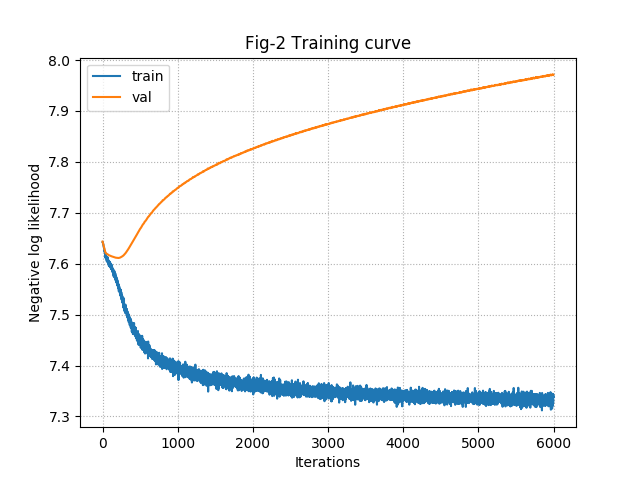

In [15]:
plt.plot(list(np.arange(0, len(train_log))), train_log, label='train')
plt.plot(list(np.arange(0, len(val_log))), val_log, label='val')
plt.legend()
plt.title("Fig-2 Training curve")
plt.xlabel("Iterations")
plt.ylabel("Negative log likelihood")
plt.grid(linestyle=':')

<IPython.core.display.Javascript object>


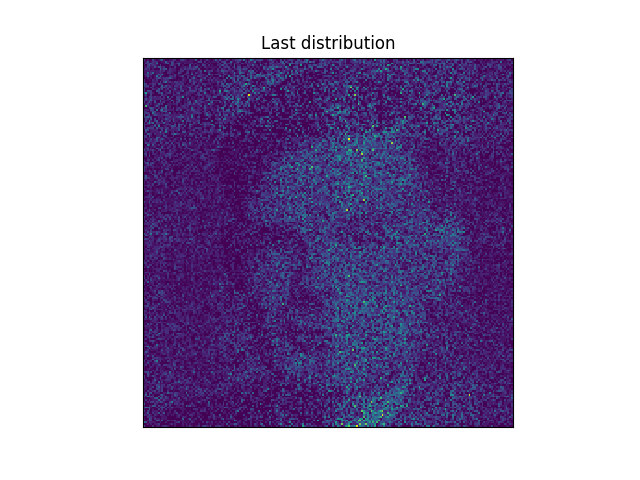

Test NLL 7.975 (bits per dim)


In [16]:
load_checkpoint('./checkpoints/MLP/last.pth.tar', model)
dist_last = model.get_distribution()
plt.imshow(dist_last)
plt.xticks([])
plt.yticks([])
plt.title("Last distribution")

p_test, _, _ = model(X_test)
nll_test = get_NLL(p_test) / 2.0
print("Test NLL {:.3f} (bits per dim)".format(nll_test))

<IPython.core.display.Javascript object>


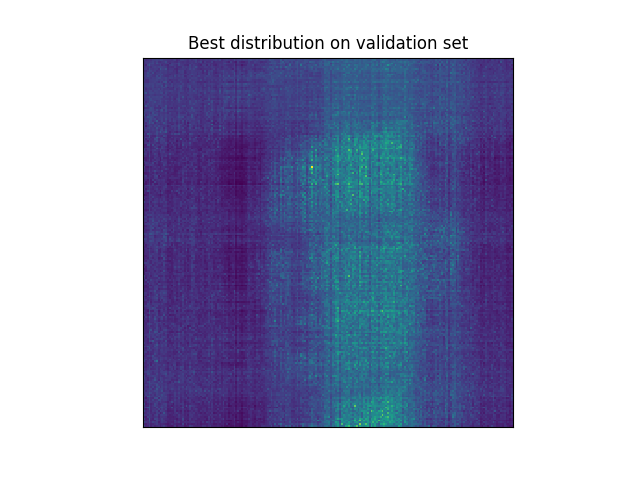

Test NLL 7.613 (bits per dim)


In [17]:
load_checkpoint('./checkpoints/MLP/best.pth.tar', model)
dist_best = model.get_distribution()
plt.imshow(dist_best)
plt.xticks([])
plt.yticks([])
plt.title("Best distribution on validation set")

p_test, _, _ = model(X_test)
nll_test = get_NLL(p_test) / 2.0
print("Test NLL {:.3f} (bits per dim)".format(nll_test))

<IPython.core.display.Javascript object>


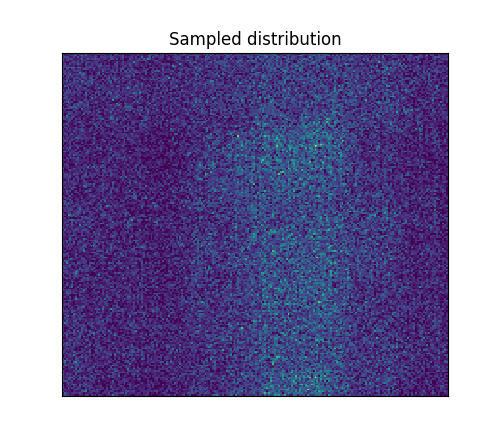

Text(0.5, 1.0, 'Sampled distribution')

In [18]:
# sample from estimated distribution
samples_made = sample2d(dist_best / np.sum(dist_best), 100000)
_, _, _, fig = plt.hist2d(samples_made[:, 1], samples_made[:, 0], bins=[200, 200])
ax = fig.axes
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
plt.title("Sampled distribution")

### Remarks
The training curve shows that the NLL(Negative log-likelihood) of the validation set went up at a specific point while the NLL of the training set continuously went down. This is a typical phenomenon of overfitting. In our case, this is because the distribution of the validation set and the training set are quite different, as can be seen from Figure 1. This also leads to the conclusion that in our case, the NLL of the validation set may not be a good criterion for evaluating the model performance. The model with the lowest NLL in the validation set may not be the best model, as can be seen from the visualization of the learned distribution of different models. More data will help relieve this phenomenon, try sampling 1,000,000 points and you will see.